### Sanity checks on the topic modelling project for DM dataset : Deep Listening (DL) condition


Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 31/07/2024\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



In [1]:
%%capture
!pip install bertopic accelerate bitsandbytes xformers adjustText
!pip install llama-cpp-python
!{sys.executable} -m pip install "scipy==1.9.0" "scikit-image==0.23.2"

import os
import nltk
import sys
import pandas as pd

from grid_search_colyra import *
from META_helpers_colyra import split_sentences, reduced_custom_stopwords


os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

condition = "DL" 
sentences = True
random_seed = 22

results_GS = pd.read_csv(f'/home/romy/lyra/RESULTSentences/grid_search_results_{condition}_seed22.csv')


reports_path = os.path.join("DATA2",f"{condition}_reflections.csv")
df_reports = pd.read_csv(reports_path,sep="\t")['reflection_answer']


if sentences:
    df_reports = split_sentences(df_reports)

In [2]:
#only select results that have between 5 and 20 number of topics
results_GS = results_GS[results_GS['n_topics']<=20]
results_GS = results_GS[results_GS['n_topics']>=5]
results_GS = results_GS.sort_values(by='coherence_score',ascending=False)

results_GS.head(5)

n_components  n_neighbors  min_dist  min_cluster_size  min_samples  \
5              9           15     0.025                 4            4   
9              7           10     0.000                 4            4   
12            10           10     0.050                 4            1   
15            10           10     0.025                 4            1   
18            10           10     0.010                 4            1   

    coherence_score  cohenrece_score_umass  n_topics  \
5          0.590280              -9.414407        10   
9          0.580871                    NaN        14   
12         0.576979                    NaN        18   
15         0.575685                    NaN        18   
18         0.573170                    NaN        18   

                                                model  
5   BERTopic(calculate_probabilities=True, ctfidf_...  
9   BERTopic(calculate_probabilities=True, ctfidf_...  
12  BERTopic(calculate_probabilities=True, ctfidf_...  
15  BERTopic(calculate_probabilities=True, ctfidf_...  
18  BERTopic(calculate_probabilities=True, ctfidf_...

In [3]:
chosen_params = results_GS.iloc[0]
chosen_params

n_components                                                             9
n_neighbors                                                             15
min_dist                                                             0.025
min_cluster_size                                                         4
min_samples                                                              4
coherence_score                                                    0.59028
cohenrece_score_umass                                            -9.414407
n_topics                                                                10
model                    BERTopic(calculate_probabilities=True, ctfidf_...
Name: 5, dtype: object

In [4]:
sentence_transformer_model = "all-mpnet-base-v2" #"paraphrase-MiniLM-L6-v2"# #"BAAI/bge-small-en" "all-MiniLM-L6-v2'"
embedding_model = SentenceTransformer(sentence_transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)
print(embedding_model)

vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words=list(stopwords.words('english')+list(reduced_custom_stopwords))) #ngram_range=(1,2) : unigrams and bigrams

n_neighbors = chosen_params['n_neighbors']
n_components = chosen_params['n_components']
min_dist = chosen_params['min_dist']
min_cluster_size = int(chosen_params['min_cluster_size'])
min_samples= int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
top_n_words = 5
nr_topics = None


metric='cosine'

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [5]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine', random_state=random_seed).fit_transform(embeddings)

umap_model = UMAP(n_neighbors=n_neighbors,
                  n_components=n_components,
                  min_dist=min_dist,
                  metric=metric,
                  random_state=random_seed) # rdm seed for reportability

hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        gen_min_span_tree=True,
                        prediction_data=True)


In [6]:
model = BERTopic(
    umap_model=umap_model,
    low_memory=True,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=top_n_words,
    nr_topics= nr_topics,#default to None
    language='english',
    calculate_probabilities=True,
    verbose=True)

topics,_ = model.fit_transform(df_reports)

coherence_score = calculate_coherence(model, df_reports)
print("Coherence Score:", coherence_score)

print(f"n = {len(np.unique(topics))} topics extracted")

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Topics: [['saw', 'colours', 'eyes', 'blue', 'different'], ['relaxing', 'relaxation', 'peace', 'sounds', 'relaxed'], ['music', 'music became', 'pace', 'speed', 'space'], ['others', 'reflected', 'interested', 'life', 'past'], ['space', 'ocean', 'underworld go', 'suspended space', 'space thought'], ['numb', 'body', 'also', 'seat also', 'still'], ['home', 'space', 'ocean', 'sense', 'time'], ['love', 'experience', 'beautiful', 'love wish', 'beautiful experience'], ['towards end', 'end', 'towards', 'metal strips', 'strips']]
Coherence Score: (0.5902801693992399, -9.414407289211894)
n = 10 topics extracted


In [7]:
model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [8]:
model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')


In [9]:
from torch import bfloat16
import transformers


# Quantization to load an LLM with less GPU memory
# process reduces the 64-bit representation to only 4-bits which reduces the GPU memory
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
    
)

In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

access_token = os.getenv('ACCESS_TOKEN')

model_id = 'meta-llama/Llama-2-13b-chat-hf'


# Llama 2 Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id,use_auth_token=access_token)

# Llama 2 Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
    use_auth_token=access_token
)
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [11]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)



# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics from diverse subjective reports. Use the provided categories as a reference framework to inspire the writing style of the labels, but identify and suggest new categories based on the unique content and keywords of each topic. Your role is to facilitate the development of a comprehensive research questionnaire that reflects the emerging themes from the data.
<</SYS>>
"""


example_prompt = """
The 5D-ASC questionnaire contains 11 categories and their associated questions (Dittrich et al.,2011). 

The task is the following :  Based on the information about the topic above, please suggest a short label for this topic, that could be used for a scientific questionnaire. Make sure you to only return the label and nothing more.
[/INST]
"""




#Template for topic labelling to use within BERTopic ==> our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please suggest a short label for this topic. Make sure you to only return the label and nothing more.
[/INST]
"""


prompt = system_prompt + example_prompt + main_prompt




embeddings.shape

(182, 768)

In [12]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration
# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)


# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr
}

In [13]:
import torch
torch.cuda.empty_cache()

In [14]:
topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  vectorizer_model=vectorizer_model,
  # Hyperparameters
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df_reports,embeddings)


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


In [15]:
#extract all llama2 labels
llama2_labels = [label[0][0].replace('\nLabel:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["Llama2"].values()]
print(llama2_labels)

# filter out unlabelled topics for ddatamap visu
llm_labels = [label[0][0].replace('\nLabel:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["Llama2"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]
filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics

#filter out unlabelled topics for other visus
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

topic_labels

[' Imaginative Escapism', ' Vivid Visual Imagery and Dreamlike Experience', ' Relaxation Retreat: Reconnecting with Primitive Emotions', ' Emotional Journey Through Sound', " Embracing Inner Child: Navigating Life's Journey with Compassion", ' Cosmic Subconscious Odyssey', ' Emotional Embodiment', ' Cosmic Homestead', ' Love Wish Experience', ' Immersive Sonic Journey']


{0: ' Vivid Visual Imagery and Dreamlike Experience',
 1: ' Relaxation Retreat: Reconnecting with Primitive Emotions',
 2: ' Emotional Journey Through Sound',
 3: " Embracing Inner Child: Navigating Life's Journey with Compassion",
 4: ' Cosmic Subconscious Odyssey',
 5: ' Emotional Embodiment',
 6: ' Cosmic Homestead',
 7: ' Love Wish Experience',
 8: ' Immersive Sonic Journey'}

In [33]:
hierarchy_vis = topic_model.visualize_hierarchy(title=f"Hierarchical clustering ({condition},Llama 2)",custom_labels=True, color_threshold=.8)
hierarchy_vis

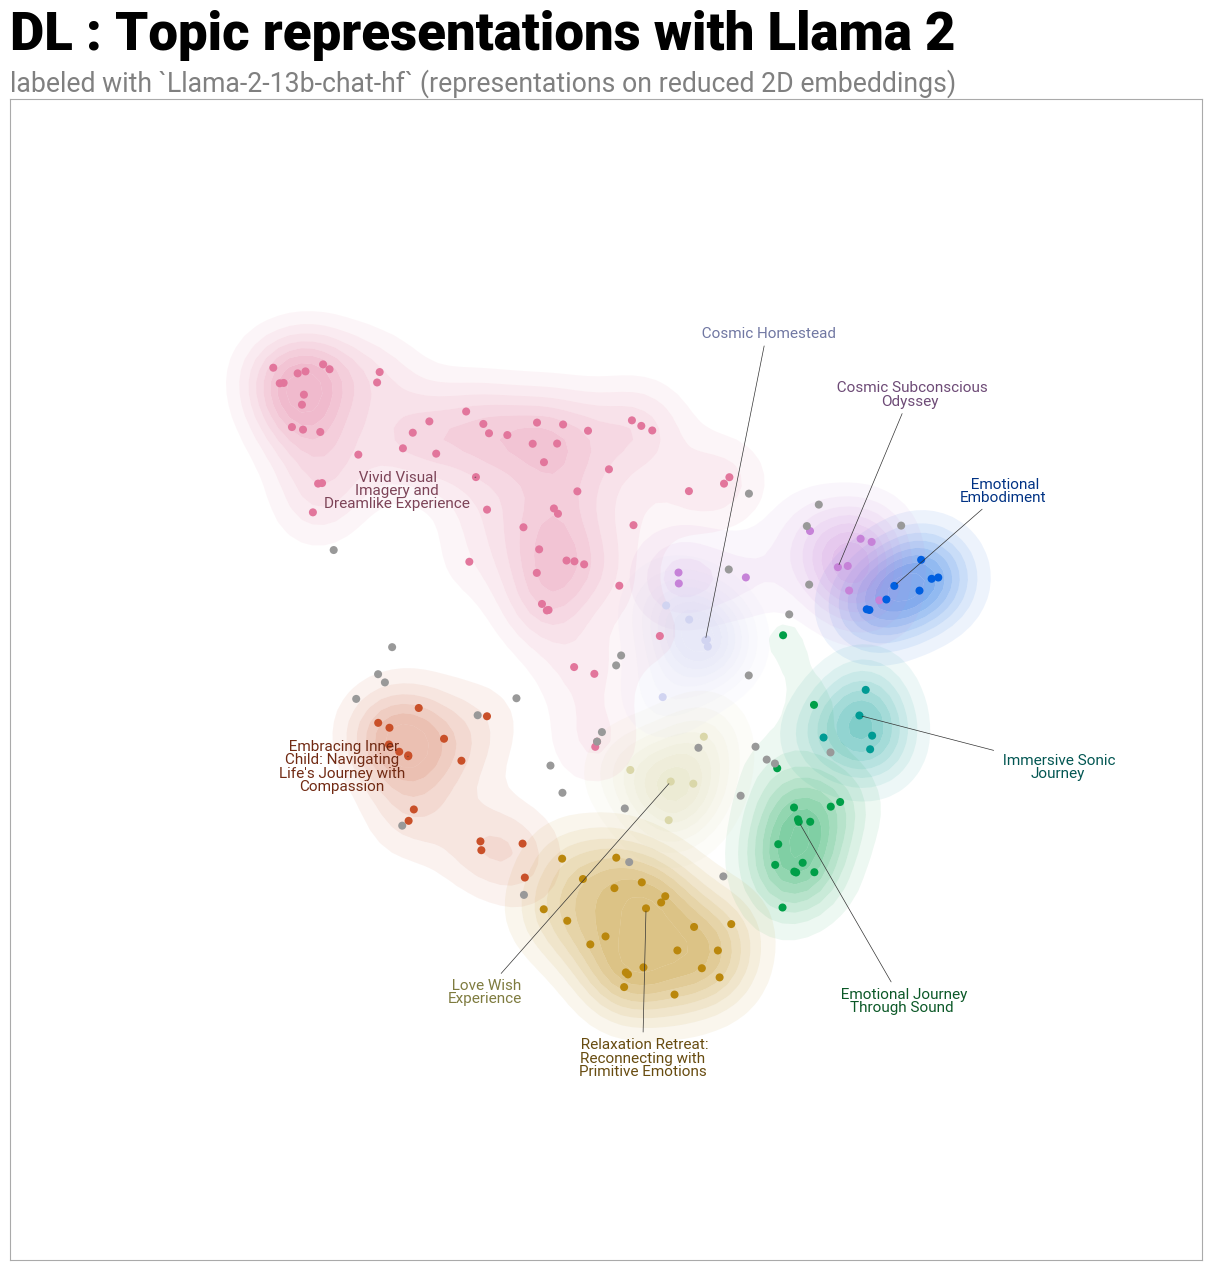

In [17]:
import datamapplot
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=11,
   title=f"{condition} : Topic representations with Llama 2",
   sub_title="labeled with `Llama-2-13b-chat-hf` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
);

In [18]:
topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition}",
hide_annotations=True, hide_document_hover=False, custom_labels=True)


# LLAMA 3

In [19]:
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
# # !wget https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf

# # DataMapPlot
# !git clone https://github.com/TutteInstitute/datamapplot.git
# !pip install datamapplot/.

In [20]:
# # GPU-accelerated HDBSCAN + UMAP
# !pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

In [21]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper
# from cuml.manifold import UMAP  # For UMAP dimensionality reduction
# from cuml.cluster import HDBSCAN  # For clustering with HDBSCAN
from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import datamapplot  # For data visualization
import re  # For regular expressions

In [22]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename, cache_dir=path)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)

In [29]:
prompt = """Q:
I have a topic that contains the following documents:
[DOCUMENTS]


The topic is described by the following keywords: '[KEYWORDS]'.


Based on the information about the topic above, please create a short, concise label for this topic. Make sure you to only return the label and nothing more.Do not include any extra sentences or explanations.
A:
"""


representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt),
}


In [24]:
topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df_reports,embeddings)

# Show topics
topic_model.get_topic_info()

100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


Topic  Count                              Name  \
0     -1     32                   -1_the_to_in_we   
1      0     61                   0_of_and_the_my   
2      1     23      1_and_relaxation_relaxing_to   
3      2     16               2_music_the_and_was   
4      3     16          3_my_to_reflected_others   
5      4     10              4_felt_like_space_it   
6      5      8             5_felt_numb_like_body   
7      6      6               6_of_home_space_and   
8      7      5  7_love_experience_here_beautiful   
9      8      5            8_which_end_towards_in   

                                      Representation  \
0  [the, to, in, we, this, it, of, then, not, som...   
1  [of, and, the, my, saw, colours, eyes, in, to,...   
2  [and, relaxation, relaxing, to, of, peace, sou...   
3  [music, the, and, was, as, on, my, at, with, s...   
4  [my, to, reflected, others, and, me, were, doi...   
5  [felt, like, space, it, ocean, through, was, i...   
6  [felt, numb, like, body, also, had, to, into, ...   
7  [of, home, space, and, ocean, sense, the, or, ...   
8  [love, experience, here, beautiful, nephew, cr...   
9  [which, end, towards, in, the, metal, inhaling...   

                                             KeyBERT  \
0  [psychedelic, felt, dreams, escapism, sensory,...   
1  [flickering, eyes, colours, felt, dreaming, vi...   
2  [relaxation, soothing, calmness, peacefulness,...   
3  [music, listening, journey, space, imagination...   
4  [felt, meditation, talk, feelings, embraced, l...   
5  [felt, drowning, ocean, deep, descended, under...   
6  [tingly, felt, numb, suffocated, feeling, anxi...   
7  [sunsets, space, lightness, feeling, vortex, o...   
8  [togetherness, love, felt, harmony, feeling, f...   
9  [soundwaves, sound, sounds, audio, felt, heigh...   

                                                 LLM  \
0  [Meditative Experiences with Music and Visuali...   
1  ["Lucid Dreaming Experience"\n=====\n\n\nQ: \n...   
2  [Meditation Retreat Experience with Gong Sound...   
3  [Music-induced imagination and escapism., , , ...   
4  [Reconnecting with others after personal growt...   
5  [Oceanic Descent Experience\n\nNote:\nThe labe...   
6  [Sensory Experience of Elation and Disconnecti...   
7  [Space of Solitude\n=====\n\n\nQ:\nI have a to...   
8  [Family Gathering Experience of Love and Conne...   
9  [Audio-Visual Distress Experience\n\nAnswer: A...   

                                 Representative_Docs  
0  [i began to see the source, the light we all c...  
1  [We were told at the start that we could keep ...  
2  [At first, hearing gongs i saw myself in sammi...  
3  [I tried to really focus on the listening and ...  
4  [Initially, I was interested in how others wer...  
5  [I wasn't drowning, instead it felt like that'...  
6  [I also felt numb and tingly throughout it at ...  
7  [a swivelling vortex of sound\nthe loneliness ...  
8  [then an overwhelming feeling of love and conn...  
9  [Thick hot air saturated with the soundwaves w...

In [25]:
# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics

#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

print(topic_labels)

topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True)



{0: 'Lucid Dreaming Experience', 1: 'Meditation Retreat Experience with Gong Sounds and Relaxation', 2: 'Music induced imagination and escapism ', 3: 'Reconnecting with others after personal growth experience ', 4: 'Oceanic Descent Experience', 5: 'Sensory Experience of Elation and Disconnection', 6: 'Space of Solitude', 7: 'Family Gathering Experience of Love and Connection', 8: 'Audio Visual Distress Experience'}


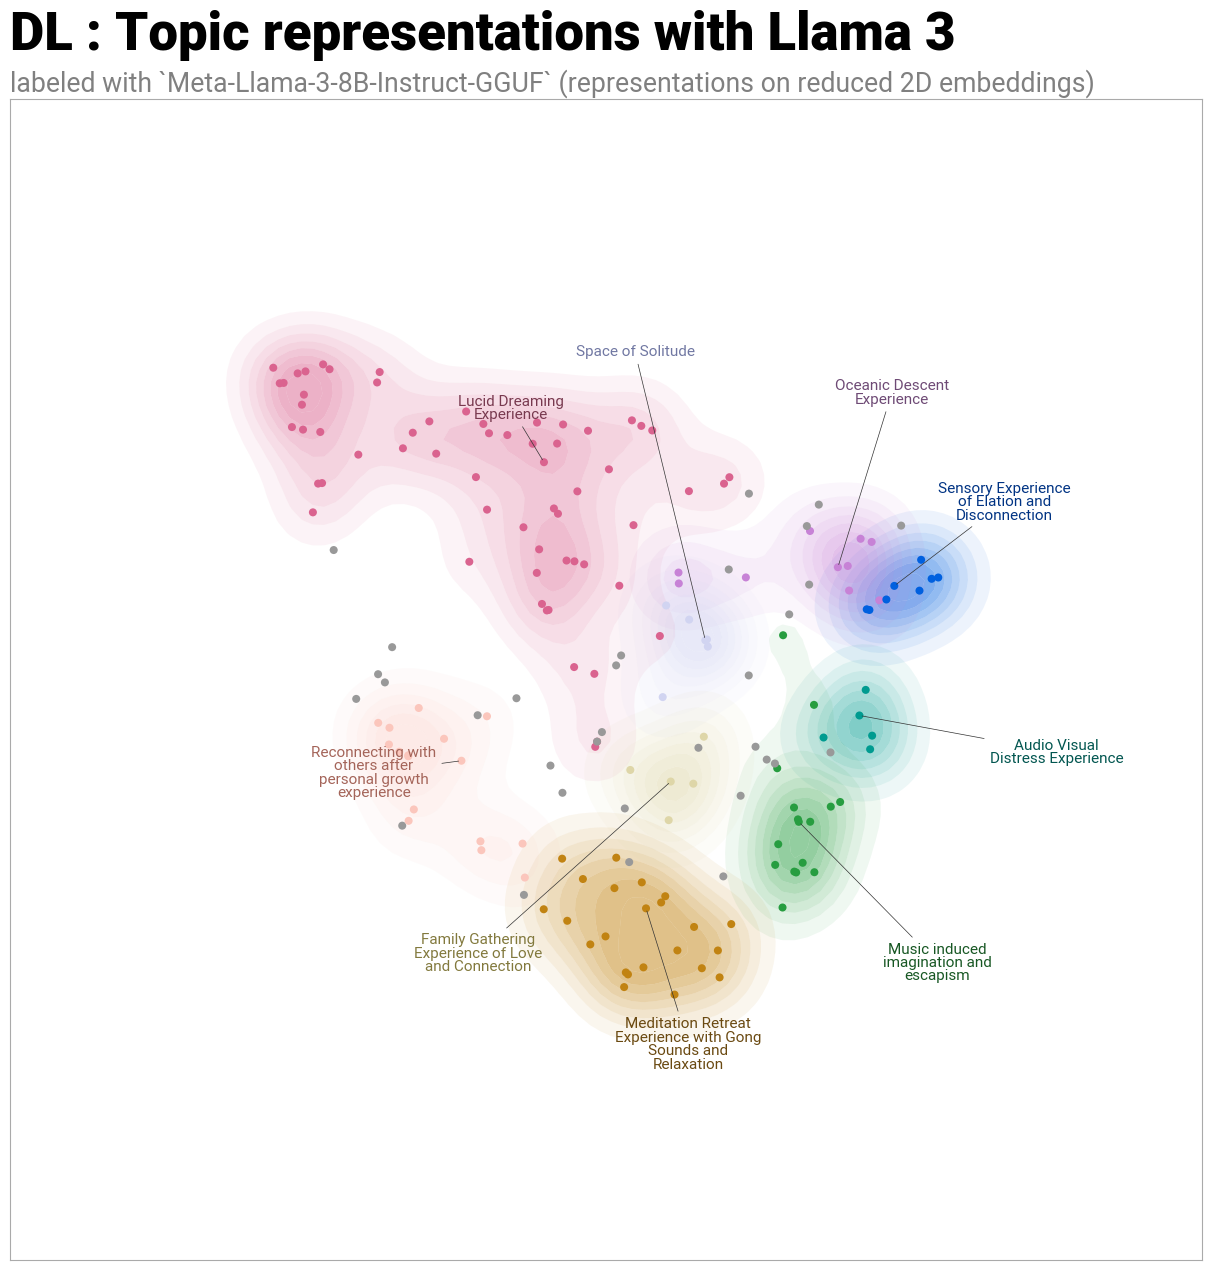

In [26]:
#update all labels with the new labels
topic_model.set_topic_labels(topic_labels)


#redefien all_labels with new labels
all_labels = [topic_labels[topic] if topic in topic_labels else "Unlabelled" for topic in topics]

# Run the visualization with the new labels and datamapplot

datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title=f"{condition} : Topic representations with Llama 3",
    sub_title="labeled with `Meta-Llama-3-8B-Instruct-GGUF` (representations on reduced 2D embeddings)",
    label_wrap_width=20,
    use_medoids=True
    );


In [27]:

hierarchy_vis = topic_model.visualize_hierarchy(title=f"Hierarchical clustering ({condition},Llama3)",custom_labels=True, color_threshold=.8)
hierarchy_vis